In [1]:
import ee
import geopandas as gpd
import matplotlib.pyplot as plt

# Authenticate and initialize GEE
ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


In [11]:
import urllib.request
from PIL import Image
import numpy as np

In [47]:
# Define your region of interest and data
lhz = ee.FeatureCollection("projects/awatford-bauchlab/assets/KE_LHZ_2011")
gaul = ee.FeatureCollection("FAO/GAUL/2015/level2")
cover = ee.Image("MODIS/061/MCD12Q1/2022_01_01").select('LC_Type1')

Kenya = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Kenya')).union()
KE05 = lhz.filter(ee.Filter.eq('LZCODE', 'KE05'));
KE09 = lhz.filter(ee.Filter.eq('LZCODE', 'KE09'));
KE16 = lhz.filter(ee.Filter.eq('LZCODE', 'KE16'));
KE16_mask = cover.eq(ee.Image.constant(12).clip(KE16));
cover = cover.updateMask(KE16_mask);

# Define visualization parameters
cover_vis_params = {
    'min': 1,
    'max': 17,
    'palette': [
        '05450a', '086a10', '54a708', '78d203', '009900',  # forest
        'c6b044', 'dcd159',  # shrubs
        'dade48', 'fbff13',  # savannahs
        'b6ff05',  # grasslands
        '27ff87',  # wetlands
        'c24f44',  # croplands
        'a5a5a5',  # urban / built up
        'ff6d4c',  # cropland / natural vegetation mosaics
        '69fff8',  # permanent snow
        'f9ffa4',  # barren
        '1c0dff'  # water
    ]
}

# Set scale (resolution) to avoid oversized image
scale = 1000  # Set scale to 1000 meters per pixel (adjust if needed)

In [48]:
# Use GeoPandas to fetch the administrative boundaries of Kenya
kenya_fc = Kenya.getInfo()
kenya_geojson = gpd.GeoDataFrame.from_features(kenya_fc['features'])
KE05_fc = KE05.getInfo()
KE05_geojson = gpd.GeoDataFrame.from_features(KE05_fc['features'])
KE09_fc = KE09.getInfo()
KE09_geojson = gpd.GeoDataFrame.from_features(KE09_fc['features'])
KE16_fc = KE16.getInfo()
KE16_geojson = gpd.GeoDataFrame.from_features(KE16_fc['features'])

In [49]:
# Clip cover to the region of interest and export it
cover_clipped = cover.clip(Kenya)

# Get a URL for the image with reduced scale
url = cover_clipped.getThumbURL({
    'min': 1,
    'max': 17,
    'palette': cover_vis_params['palette'],
    'region': Kenya.geometry().bounds().getInfo(),  # Adjust the region to Kenya
    'scale': scale  # Reduce the resolution by setting a larger scale
})

In [50]:
img = np.array(Image.open(urllib.request.urlopen(url)))

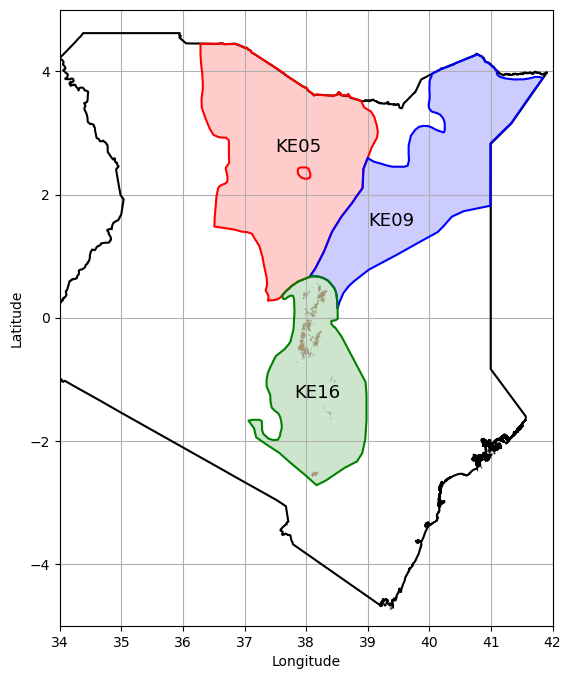

In [51]:
# Plot using Matplotlib and Geopandas
fig, ax = plt.subplots(figsize=(10, 8))
kenya_geojson.boundary.plot(ax=ax, color='black')
KE05_geojson.boundary.plot(ax=ax, color='red')
KE05_geojson.plot(ax=ax, color='red', alpha=0.2)
KE09_geojson.boundary.plot(ax=ax, color='blue')
KE09_geojson.plot(ax=ax, color='blue', alpha=0.2)
KE16_geojson.boundary.plot(ax=ax, color='green')
KE16_geojson.plot(ax=ax, color='green', alpha=0.2)

# Add labels, grid, and title
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
# ax.set_title("Land Cover in Kenya")
ax.grid(True)
ax.annotate('KE05', (37.5,2.7), fontsize=13)
ax.annotate('KE09', (39,1.5), fontsize=13)
ax.annotate('KE16', (37.8,-1.3), fontsize=13)
ax.imshow(img, extent=[34, 42, -5, 5], alpha=0.6)  # Adjust to your region bounds

# Show the figure
plt.show()